In [1]:
import random
import torch as tc
import numpy as np
import qutip as qt
import function as my
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [XX,XY,XZ,
                  YX,YY,YZ,
                  ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect

O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]


In [3]:
SEED =42
np.random.seed(SEED)
tc.manual_seed(SEED) 
random.seed(SEED)
################## Definindo os parametros #######################

Js          = [random.uniform(-1,1) for _ in range(9)]
dissipation = [random.uniform(0,1) for _ in range(4)]
tfinal      = 2*np.pi
N           = 200


valor_esperado_data  = data_qubit_two_crosstalk(Js,dissipation,tfinal,N,O_op,device="cpu")

# for i in range(len(O_op)):
#     plt.plot(valor_esperado_data[:,i].cpu() ,label=f"O_{i}")

# plt.legend()
# plt.show()
print(Js,dissipation)

[0.2788535969157675, -0.9499784895546661, -0.4499413632617615, -0.5535785237023545, 0.4729424283280248, 0.3533989748458226, 0.7843591354096908, -0.8261223347411677, -0.15615636062945915] [0.029797219438070344, 0.21863797480360336, 0.5053552881033624, 0.026535969683863625]


c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [4]:
# SEED =42
# np.random.seed(SEED)
# tc.manual_seed(SEED) 
# random.seed(SEED)

neuronio = [50,50]
X_vector   = my.Rede(
        neuronio    = neuronio,
        input_      = 1,
        output_     = len(O_op),
        activation  =[tc.nn.Tanh()]*len(neuronio),
        creat_p     =True,
        N_of_paramater= 9 +4)
opt = tc.optim.Adam(X_vector.parameters(),
        lr = 0.001 )
time =  tc.linspace(
        0,
        tfinal,
        N,
        dtype   = tc.float32,
        requires_grad = True).reshape((-1, 1))
index_data = np.random.randint(0,N,size=50)


std = 0.00
valor_esperado_data = data_qubit_two_crosstalk(Js,dissipation,tfinal,N,O_op,)
random_data = tc.normal(mean=0.0, std=std, size=valor_esperado_data.shape)
valor_esperado_data_noisy = valor_esperado_data + random_data   

X_vector.parametro

c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Parameter containing:
tensor([0.5281, 0.6145, 0.2536, 0.4515, 0.3883, 0.9184, 0.9340, 0.7055, 0.4969,
        0.8750, 0.0963, 0.7089, 0.2094], requires_grad=True)

In [5]:
# std = 0.00
# valor_esperado_data = data_qubit_two_crosstalk(Js,dissipation,tfinal,N,O_op,)
# random_data = tc.normal(mean=0.0, std=std, size=valor_esperado_data.shape)
# valor_esperado_data_noisy = valor_esperado_data + random_data   
    

In [6]:
epocas  = 10000
LOSS    = []
LOSS1   = []
LOSS2   = []
hisorty_of_param = []
for _ in tqdm(range(epocas)):
    ####### Forward pass #######
    y  = X_vector(time)     
    
    ######## Los edo #######
    dX_dt = []
    for i in range(y.shape[1]):
        dX_dt.append(tc.autograd.grad(outputs = y[:, i], 
                                    inputs = time,
                                    grad_outputs = tc.ones_like(y[:, i]),
                                    #retain_graph = True,
                                    create_graph = True)[0])
    dX_dt   = tc.cat(dX_dt, dim=1)
    
    IX,IY,IZ,XI,XX,XY,XZ = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4],y[:, 4:5], y[:, 5:6],y[:, 6:7]
    YI,YX,YY,YZ,ZI,ZX,ZY,ZZ = y[:, 7:8], y[:, 8:9], y[:, 9:10],y[:, 10:11], y[:, 11:12], y[:,12:13], y[:,13:14], y[:,14:15]

    JXX,JXY,JXZ,JYX,JYY,JYZ,JZX,JZY,JZZ,gamma1,gamma2,gamma3,gamma4 = X_vector.parametro
    
    LOSS_edo  = 0
    LOSS_edo += (dX_dt[:,0:1] - ( +IX*(-0.5*gamma3 - 2.0*gamma4) +(-1.0*JXZ)*XY +JXY*XZ +(-1.0*JYZ)*YY +(1.0*JYY)*YZ +(-1.0*JZZ)*ZY +(1.0*JZY)*ZZ))**2
    LOSS_edo += (dX_dt[:,1:2] - ( +IY*(-0.5*gamma3 - 2.0*gamma4) +(1.0*JXZ)*XX +(-1.0*JXX)*XZ +JYZ*YX +(-1.0*JYX)*YZ +(1.0*JZZ)*ZX +(-JZX)*ZZ))**2
    LOSS_edo += (dX_dt[:,2:3] - ( (-1.0*gamma3) +IZ*(-1.0*gamma3) +(-1.0*JXY)*XX +(1.0*JXX)*XY +(-1.0*JYY)*YX +JYX*YY +(-1.0*JZY)*ZX +(1.0*JZX)*ZY))**2
    LOSS_edo += (dX_dt[:,3:4] - ( +XI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JZX)*YX +(-1.0*JZY)*YY +(-1.0*JZZ)*YZ +JYX*ZX +(1.0*JYY)*ZY +(1.0*JYZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,4:5] - ( +IY*(-1.0*JXZ) +IZ*(1.0*JXY) +XX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JZX)*YI +(1.0*JYX)*ZI))**2
    LOSS_edo += (dX_dt[:,5:6] - ( +IX*JXZ +IZ*(-1.0*JXX) +XY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JZY)*YI +(1.0*JYY)*ZI))**2
    LOSS_edo += (dX_dt[:,6:7] - ( +IX*(-1.0*JXY) +IY*(1.0*JXX) +XI*(-1.0*gamma3) +XZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JZZ)*YI +(1.0*JYZ)*ZI))**2
    LOSS_edo += (dX_dt[:,7:8] - ( +(1.0*JZX)*XX +JZY*XY +(1.0*JZZ)*XZ +YI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JXX)*ZX +(-1.0*JXY)*ZY +(-JXZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,8:9] - ( +IY*(-1.0*JYZ) +IZ*(1.0*JYY) +JZX*XI +YX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JXX)*ZI))**2
    LOSS_edo += (dX_dt[:,9:10] - ( +IX*(1.0*JYZ) +IZ*(-1.0*JYX) +(1.0*JZY)*XI +YY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JXY)*ZI))**2
    LOSS_edo += (dX_dt[:,10:11] - ( +IX*(-1.0*JYY) +IY*JYX +(1.0*JZZ)*XI +YI*(-1.0*gamma3) +YZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-JXZ)*ZI))**2
    LOSS_edo += (dX_dt[:,11:12] - ( (-1.0*gamma1) +(-1.0*JYX)*XX +(-1.0*JYY)*XY +(-1.0*JYZ)*XZ +(1.0*JXX)*YX +JXY*YY +(1.0*JXZ)*YZ +ZI*(-1.0*gamma1)))**2
    LOSS_edo += (dX_dt[:,12:13] - ( +IX*(-1.0*gamma1) +IY*(-1.0*JZZ) +IZ*(1.0*JZY) +(-1.0*JYX)*XI +(1.0*JXX)*YI +ZX*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4)))**2
    LOSS_edo += (dX_dt[:,13:14] - ( +IX*(1.0*JZZ) +IY*(-1.0*gamma1) +IZ*(-JZX) +(-1.0*JYY)*XI +JXY*YI +ZY*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4)))**2
    LOSS_edo += (dX_dt[:,14:15] - ( +IX*(-1.0*JZY) +IY*(1.0*JZX) +IZ*(-1.0*gamma1) +(-1.0*JYZ)*XI +(1.0*JXZ)*YI +ZI*(-1.0*gamma3) +ZZ*(-1.0*gamma1 - 1.0*gamma3)))**2
    LOSS_edo = LOSS_edo.mean() 
    ####### loss data(expected values) #######
    LOSS_data = tc.mean((y[index_data,:]  - valor_esperado_data[index_data,:])**2) 
    
    ####### Loss total #######
    loss_i = LOSS_edo*0.01 + LOSS_data#+ tc.sum(X_vector.parametro**2) + tc.sum(tc.abs(X_vector.parametro))
    
    ####### Backpropagation #######
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    LOSS1.append(LOSS_edo.cpu().detach().numpy())
    LOSS2.append(LOSS_data.cpu().detach().numpy())
    LOSS.append(loss_i.cpu().detach().numpy())

100%|██████████| 10000/10000 [01:56<00:00, 85.98it/s]


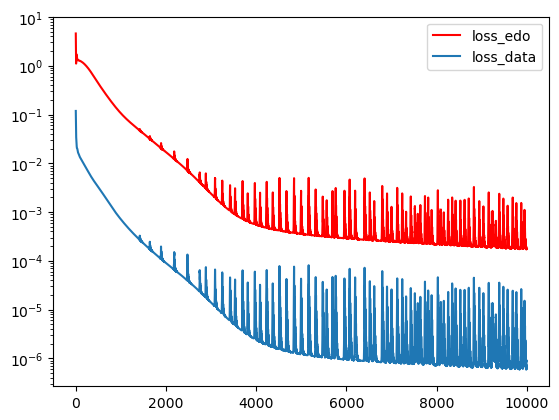

Valor final: Parameter containing:
tensor([ 0.2785, -0.9515, -0.4487, -0.5549,  0.4744,  0.3524,  0.7824, -0.8251,
        -0.1546,  0.0300,  0.2183,  0.5059,  0.0257], requires_grad=True)


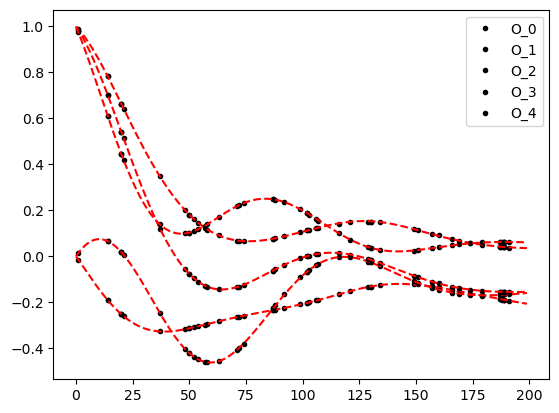

In [7]:
#plt.plot(LOSS,"k.",label="loss_total")
plt.plot(LOSS1,'r-',label="loss_edo")
plt.plot(LOSS2,label="loss_data")
plt.yscale("log")
plt.legend()
plt.show()
print("Valor final:",X_vector.parametro)


X_vector.eval()
X_  = X_vector(time).detach().numpy()

for i in range(5):
    plt.plot(index_data,valor_esperado_data_noisy[index_data,i].cpu(),"k." ,label=f"O_{i}")
    plt.plot(X_[:,i],"r--")

# plt.plot(X_[:,3],"--",label="sigmaI_Y")

plt.legend()
plt.show()

In [ ]:
opt = tc.optim.LBFGS(X_vector.parameters(), lr = 0.01, max_iter=1000)

epocas = 1000
for _ in tqdm(range(epocas)):
    def closure():
        opt.zero_grad()
        y = X_vector(time)

        # compute dX_dt
        dX_dt = []
        for i in range(y.shape[1]):
            dX_dt.append(tc.autograd.grad(outputs=y[:, i],
                                          inputs=time,
                                          grad_outputs=tc.ones_like(y[:, i]),
                                          create_graph=True)[0])
        dX_dt = tc.cat(dX_dt, dim=1)

        # unpack observables and parameters (same as before)
        IX,IY,IZ,XI,XX,XY,XZ = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4], y[:, 4:5], y[:, 5:6], y[:, 6:7]
        YI,YX,YY,YZ,ZI,ZX,ZY,ZZ = y[:, 7:8], y[:, 8:9], y[:, 9:10], y[:, 10:11], y[:, 11:12], y[:,12:13], y[:,13:14], y[:,14:15]

        JXX,JXY,JXZ,JYX,JYY,JYZ,JZX,JZY,JZZ,gamma1,gamma2,gamma3,gamma4 = X_vector.parametro

        LOSS_edo = 0
        LOSS_edo += (dX_dt[:,0:1] - ( +IX*(-0.5*gamma3 - 2.0*gamma4) +(-1.0*JXZ)*XY +JXY*XZ +(-1.0*JYZ)*YY +(1.0*JYY)*YZ +(-1.0*JZZ)*ZY +(1.0*JZY)*ZZ))**2
        LOSS_edo += (dX_dt[:,1:2] - ( +IY*(-0.5*gamma3 - 2.0*gamma4) +(1.0*JXZ)*XX +(-1.0*JXX)*XZ +JYZ*YX +(-1.0*JYX)*YZ +(1.0*JZZ)*ZX +(-JZX)*ZZ))**2
        LOSS_edo += (dX_dt[:,2:3] - ( (-1.0*gamma3) +IZ*(-1.0*gamma3) +(-1.0*JXY)*XX +(1.0*JXX)*XY +(-1.0*JYY)*YX +JYX*YY +(-1.0*JZY)*ZX +(1.0*JZX)*ZY))**2
        LOSS_edo += (dX_dt[:,3:4] - ( +XI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JZX)*YX +(-1.0*JZY)*YY +(-1.0*JZZ)*YZ +JYX*ZX +(1.0*JYY)*ZY +(1.0*JYZ)*ZZ))**2
        LOSS_edo += (dX_dt[:,4:5] - ( +IY*(-1.0*JXZ) +IZ*(1.0*JXY) +XX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JZX)*YI +(1.0*JYX)*ZI))**2
        LOSS_edo += (dX_dt[:,5:6] - ( +IX*JXZ +IZ*(-1.0*JXX) +XY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JZY)*YI +(1.0*JYY)*ZI))**2
        LOSS_edo += (dX_dt[:,6:7] - ( +IX*(-1.0*JXY) +IY*(1.0*JXX) +XI*(-1.0*gamma3) +XZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JZZ)*YI +(1.0*JYZ)*ZI))**2
        LOSS_edo += (dX_dt[:,7:8] - ( +(1.0*JZX)*XX +JZY*XY +(1.0*JZZ)*XZ +YI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JXX)*ZX +(-1.0*JXY)*ZY +(-JXZ)*ZZ))**2
        LOSS_edo += (dX_dt[:,8:9] - ( +IY*(-1.0*JYZ) +IZ*(1.0*JYY) +JZX*XI +YX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JXX)*ZI))**2
        LOSS_edo += (dX_dt[:,9:10] - ( +IX*(1.0*JYZ) +IZ*(-1.0*JYX) +(1.0*JZY)*XI +YY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JXY)*ZI))**2
        LOSS_edo += (dX_dt[:,10:11] - ( +IX*(-1.0*JYY) +IY*JYX +(1.0*JZZ)*XI +YI*(-1.0*gamma3) +YZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-JXZ)*ZI))**2
        LOSS_edo += (dX_dt[:,11:12] - ( (-1.0*gamma1) +(-1.0*JYX)*XX +(-1.0*JYY)*XY +(-1.0*JYZ)*XZ +(1.0*JXX)*YX +JXY*YY +(1.0*JXZ)*YZ +ZI*(-1.0*gamma1)))**2
        LOSS_edo += (dX_dt[:,12:13] - ( +IX*(-1.0*gamma1) +IY*(-1.0*JZZ) +IZ*(1.0*JZY) +(-1.0*JYX)*XI +(1.0*JXX)*YI +ZX*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4)))**2
        LOSS_edo += (dX_dt[:,13:14] - ( +IX*(1.0*JZZ) +IY*(-1.0*gamma1) +IZ*(-JZX) +(-1.0*JYY)*XI +JXY*YI +ZY*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4)))**2
        LOSS_edo += (dX_dt[:,14:15] - ( +IX*(-1.0*JZY) +IY*(1.0*JZX) +IZ*(-1.0*gamma1) +(-1.0*JYZ)*XI +(1.0*JXZ)*YI +ZI*(-1.0*gamma3) +ZZ*(-1.0*gamma1 - 1.0*gamma3)))**2
        LOSS_edo = LOSS_edo.mean()

        LOSS_data = tc.mean((y[index_data,:] - valor_esperado_data[index_data,:])**2)
        loss_i = LOSS_edo + LOSS_data

        loss_i.backward()
        return loss_i

    # LBFGS step — pass closure
    loss_tensor = opt.step(closure)

    # recompute once (no side effects of closure multiple calls)
    with tc.enable_grad():
        y = X_vector(time)
        dX_dt = []
        for i in range(y.shape[1]):
            dX_dt.append(tc.autograd.grad(outputs=y[:, i], inputs=time, grad_outputs=tc.ones_like(y[:, i]), create_graph=True)[0])
        dX_dt = tc.cat(dX_dt, dim=1)

        IX,IY,IZ,XI,XX,XY,XZ = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4], y[:, 4:5], y[:, 5:6], y[:, 6:7]
        YI,YX,YY,YZ,ZI,ZX,ZY,ZZ = y[:, 7:8], y[:, 8:9], y[:, 9:10], y[:, 10:11], y[:, 11:12], y[:,12:13], y[:,13:14], y[:,14:15]
        JXX,JXY,JXZ,JYX,JYY,JYZ,JZX,JZY,JZZ,gamma1,gamma2,gamma3,gamma4 = X_vector.parametro

        # compute losses for logging (same formulas)
        LOSS_edo = 0
        LOSS_edo += (dX_dt[:,0:1] - ( +IX*(-0.5*gamma3 - 2.0*gamma4) +(-1.0*JXZ)*XY +JXY*XZ +(-1.0*JYZ)*YY +(1.0*JYY)*YZ +(-1.0*JZZ)*ZY +(1.0*JZY)*ZZ))**2
        # ... repeat all LOSS_edo terms as above ...
        LOSS_edo = LOSS_edo.mean()
        LOSS_data = tc.mean((y[index_data,:] - valor_esperado_data[index_data,:])**2)

    LOSS1.append(LOSS_edo.cpu().detach().numpy())
    LOSS2.append(LOSS_data.cpu().detach().numpy())
    LOSS.append(loss_tensor.cpu().detach().numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Gubio\anaconda3\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())
c:\Users\Gubio\anaconda3\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())
100%|██████████| 10000/10000 [04:45<00:00, 35.00it/s]


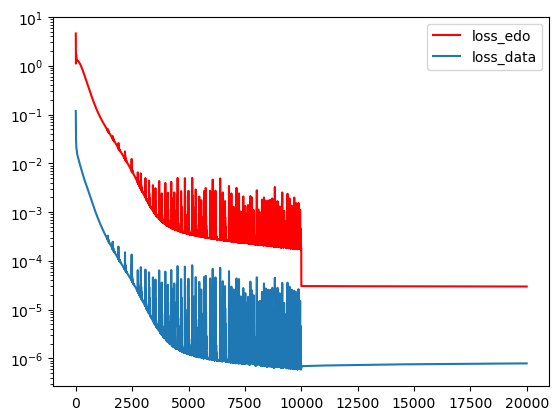

Valor final: Parameter containing:
tensor([ 0.2785, -0.9515, -0.4487, -0.5549,  0.4744,  0.3524,  0.7824, -0.8251,
        -0.1546,  0.0301,  0.2183,  0.5059,  0.0257], requires_grad=True)


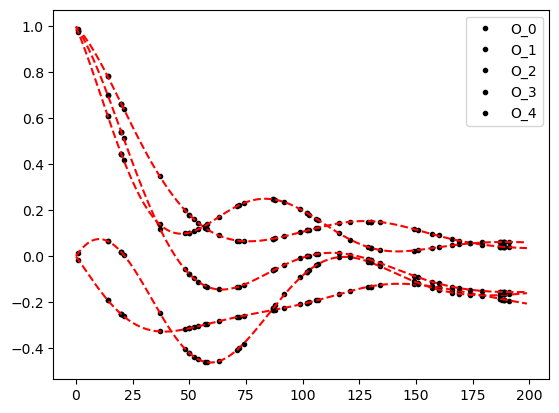

In [9]:
#plt.plot(LOSS,"k.",label="loss_total")
plt.plot(LOSS1,'r-',label="loss_edo")
plt.plot(LOSS2,label="loss_data")
plt.yscale("log")
plt.legend()
plt.show()
print("Valor final:",X_vector.parametro)


X_vector.eval()
X_  = X_vector(time).detach().numpy()

for i in range(5):
    plt.plot(index_data,valor_esperado_data_noisy[index_data,i].cpu(),"k." ,label=f"O_{i}")
    plt.plot(X_[:,i],"r--")

# plt.plot(X_[:,3],"--",label="sigmaI_Y")

plt.legend()
plt.show()

In [12]:
print(tc.tensor(Js))

tensor([ 0.2789, -0.9500, -0.4499, -0.5536,  0.4729,  0.3534,  0.7844, -0.8261,
        -0.1562])


In [10]:
abs(X_vector.parametro - tc.tensor(Js + dissipation))

tensor([0.0003, 0.0015, 0.0013, 0.0014, 0.0015, 0.0010, 0.0019, 0.0010, 0.0015,
        0.0003, 0.0003, 0.0006, 0.0008], grad_fn=<AbsBackward0>)